Adapted code from: https://gist.github.com/lmcinnes/7a39a9f103f25300aee07201bb0a9b8a

For vis: https://lmcinnes.github.io/datamapplot_examples/ArXiv_data_map_example.html

In [1]:
from dotenv import load_dotenv
import os

import numpy as np
import pandas as pd
# import datasets
import fast_hdbscan
import umap
import numba
import matplotlib.pyplot as plt

import sklearn .metrics
import vectorizers
import vectorizers.transformers
import sklearn.feature_extraction
import scipy.sparse

import sentence_transformers

from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import datamapplot
import colorcet as cc
import matplotlib

import tqdm
import string
from llama_cpp import Llama

In [2]:
# Get an API key from Anthropic AI and put it in a .env file in this directory.
# e.g.
# ANTHROPIC_API_KEY="sk-an...
load_dotenv()

True

# Building a map and clusters

In [3]:
embedding_model = sentence_transformers.SentenceTransformer("all-mpnet-base-v2", device="cuda")

In [4]:
dataset = pd.read_csv("./Search String H Results - Literature Reviews.csv", keep_default_na=False, na_values=[''])
dataset.drop_duplicates(subset=["Title"], inplace=True)
dataset = dataset[~(dataset["Manual Labelling"] == "N/A")]
dataset = dataset[(dataset["Unnamed: 41"] == "AI")]
dataset.reset_index(inplace=True)
dataset
# dataset.head()

,index,Unnamed: 0,Unnamed: 1,Unnamed: 2,Title,Year,Journal,Unnamed: 6,Unnamed: 7,Unnamed: 8,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Manual Labelling,Zero-shot labelling (lower = more relevant),Relevant to Oceanography? (lower = more relevant),Unnamed: 41,Unnamed: 42,Notes / Comments,Include / Exclude
0,0,NaN,NaN,NaN,Comparative species abundance modeling of Capi...,2020,Marine Ecology Progress Series,NaN,NaN,NaN,...,NaN,NaN,NaN,Species distribution,Marine ecology (0.412); Plankton identificatio...,1.332103,AI,NaN,NaN,Included
1,1,Liu Y.; Meng Z.; Chen W.; Liang Y.; Chen W.; C...,"Liu, Yuyao (57240197700); Meng, Zhou (72018949...",57240197700; 7201894926; 57213686853; 57218294...,Ocean Fronts and Their Acoustic Effects: A Review,2022,Journal of Marine Science and Engineering,NaN,10,12,...,2-s2.0-85144836521,NaN,NaN,Acoustic classification,Acoustic classification (0.386); Sea floor map...,1.115355,AI,NaN,NaN,Included
2,2,Luo X.; Chen L.; Zhou H.; Cao H.,"Luo, Xinwei (36995012900); Chen, Lu (581222398...",36995012900; 58122239800; 58122239900; 5771425...,A Survey of Underwater Acoustic Target Recogni...,2023,Journal of Marine Science and Engineering,NaN,11,2,...,2-s2.0-85149119509,NaN,NaN,Acoustic classification,Acoustic classification (0.368); Detection of ...,1.355405,AI,NaN,NaN,Included
3,3,Zhufeng L.; Xiaofang L.; Na W.; Qingyang Z.,"Zhufeng, Lei (57201702161); Xiaofang, Lei (579...",57201702161; 57949172700; 57948807100; 5794892...,Present status and challenges of underwater ac...,2022,Frontiers in Physics,NaN,10,NaN,...,2-s2.0-85140965810,NaN,NaN,Acoustic classification,Acoustic classification (0.379); Contaminated ...,1.38632,AI,NaN,NaN,Included
4,4,NaN,NaN,NaN,Categorizing Shallow Marine Soundscapes Using ...,2023,Journal of Marine Science and Engineering,NaN,NaN,NaN,...,NaN,NaN,NaN,Acoustic classification,Acoustic classification (0.349); Marine ecolog...,1.151325,AI,NaN,NaN,Included
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,1616,NaN,NaN,NaN,Collaboration and engagement produce more acti...,2019,Ecological Applications,NaN,NaN,NaN,...,NaN,NaN,NaN,Species distribution,Marine ecology (0.416); Invasive species monit...,1.164338,AI,NaN,NaN,Included
891,1619,NaN,NaN,NaN,Exploring seafloor stretching in mariana trenc...,2019,"OCEANS 2019 - Marseille, OCEANS Marseille 2019",NaN,NaN,NaN,...,NaN,NaN,NaN,Sea floor mapping and bathymetry,Sea floor mapping and bathymetry (0.240); Coas...,1.161257,AI,NaN,NaN,Included
892,1622,NaN,NaN,NaN,Source apportionment using receptor model base...,2019,Atmospheric Environment,NaN,NaN,NaN,...,NaN,NaN,NaN,Ocean chemistry detection,Ocean chemistry detection (0.425); Contaminate...,1.652256,AI,NaN,NaN,Included
893,1624,NaN,NaN,NaN,Portable Imaging Flow-Cytometer Using Deep Lea...,2019,"2019 Conference on Lasers and Electro-Optics, ...",NaN,NaN,NaN,...,NaN,NaN,NaN,Underwater photography,Ocean chemistry detection (0.358); Contaminate...,1.293527,AI,NaN,NaN,Included


In [5]:
data_strings = pd.DataFrame(dataset)[["Title", "Abstract"]]

In [6]:
data_vectors = embedding_model.encode(data_strings.Title + "\n\n" + data_strings.Abstract, show_progress_bar=True)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [7]:
data_map = umap.UMAP(metric="cosine", n_components=2, random_state=42).fit_transform(data_vectors)

/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


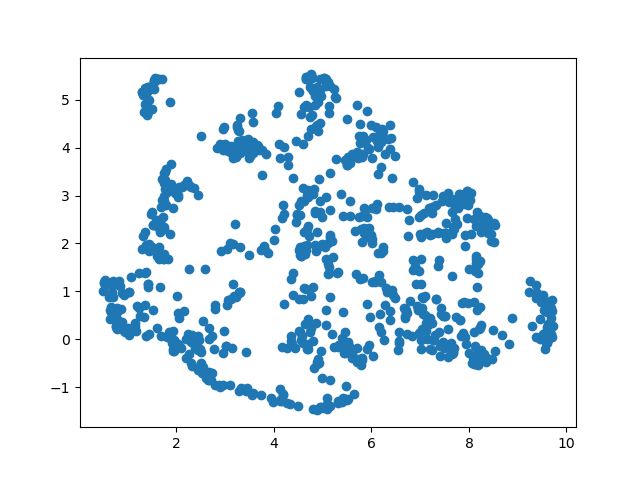

In [8]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*data_map.T)
plt.show()

Now we need to do some clustering; for this I'll use HDBCSAN (more specifically fast_hdbscan seeing as it is faster and more flexible at reaching into some of the internals). I want layers of clusters not a strict hierarchy, so we'll use some HDBSCAN based tricks to make that possible. I also want to keep track of a bunch of information which will then be used to feed back into the cluster naming -- the cluster centroid in the map layout; the cluster centroid in the original high-d embedding space; what the subclusters are; and the actual data points in each cluster.

After that we'll throw together some quick functions to get topical and distinctive sentences and extract keywords.

In [9]:
@numba.njit(fastmath=True)
def layer_from_clustering(
    point_vectors,
    point_locations,
    cluster_label_vector,
    cluster_membership_vector,
    base_clusters,
    membership_strength_threshold=0.2,
):
    n_clusters = len(set(cluster_label_vector)) - 1
    
    average_vectors = np.zeros((n_clusters, point_vectors.shape[1]), dtype=np.float32)
    average_locations = np.zeros((n_clusters, point_locations.shape[1]), dtype=np.float32)
    total_weights = np.zeros(n_clusters, dtype=np.float32)
    pointsets = [set([-1 for i in range(0)]) for i in range(n_clusters)]
    metaclusters = [set([-1 for i in range(0)]) for i in range(n_clusters)]

    for i in range(cluster_label_vector.shape[0]):
        cluster_num = cluster_label_vector[i]
        if cluster_num >= 0:
            average_vectors[cluster_num] += cluster_membership_vector[i] * point_vectors[i]
            average_locations[cluster_num] += cluster_membership_vector[i] * point_locations[i]
            total_weights[cluster_num] += cluster_membership_vector[i]
            
            if cluster_membership_vector[i] > membership_strength_threshold:
                pointsets[cluster_num].add(i)
                sub_cluster = base_clusters[i]
                if sub_cluster != -1:
                    metaclusters[cluster_num].add(sub_cluster)
                
    for c in range(n_clusters):
        average_vectors[c] /= total_weights[c]
        average_locations[c] /= total_weights[c]
        
    return average_vectors, average_locations, pointsets, metaclusters
                
            
def build_cluster_layers(
    point_vectors,
    point_locations,
    *,
    min_clusters=2,
    min_samples=5,
    base_min_cluster_size=10,
    membership_strength_threshold=0.2,
    next_cluster_size_quantile=0.8,
):
    vector_layers = []
    location_layers = []
    pointset_layers = []
    metacluster_layers = []
    
    min_cluster_size = base_min_cluster_size
    
    sklearn_tree = fast_hdbscan.hdbscan.KDTree(point_locations)
    numba_tree = fast_hdbscan.numba_kdtree.kdtree_to_numba(sklearn_tree)
    edges = fast_hdbscan.boruvka.parallel_boruvka(
        numba_tree, min_samples=min_cluster_size if min_samples is None else min_samples
    )
    sorted_mst = edges[np.argsort(edges.T[2])]
    uncondensed_tree = fast_hdbscan.cluster_trees.mst_to_linkage_tree(sorted_mst)
    new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, base_min_cluster_size)
    leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
    clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
    point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)


    cluster_ids = np.unique(clusters[clusters >= 0])
    base_clusters = clusters.copy()
    n_clusters_in_layer = cluster_ids.shape[0]
    
    base_layer = True

    while n_clusters_in_layer >= min_clusters:
        layer_vectors, layer_locations, layer_pointsets, layer_metaclusters = layer_from_clustering(
            point_vectors,
            point_locations,
            clusters,
            point_probs,
            base_clusters,
            membership_strength_threshold,            
        )
            
        if not base_layer:
            layer_metacluster_selection = np.asarray([len(x) > 1 for x in layer_metaclusters])
            layer_metaclusters = [
                list(x) for x, select in zip(layer_metaclusters, layer_metacluster_selection) if select
            ]
            layer_pointsets = [
                list(x) for x, select in zip(layer_pointsets, layer_metacluster_selection) if select
            ]
            layer_vectors = layer_vectors[layer_metacluster_selection]
            layer_locations=  layer_locations[layer_metacluster_selection]
            
        vector_layers.append(layer_vectors)
        location_layers.append(layer_locations)
        pointset_layers.append(layer_pointsets)
        metacluster_layers.append(layer_metaclusters)
        
        last_min_cluster_size = min_cluster_size
        min_cluster_size = int(np.quantile([len(x) for x in layer_pointsets], next_cluster_size_quantile))
        print(len(layer_vectors), last_min_cluster_size, min_cluster_size)
        
        new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, min_cluster_size)
        leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
        clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
        point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)
        
        cluster_ids = np.unique(clusters[clusters >= 0])
        n_clusters_in_layer = np.max(clusters) + 1
        base_layer = False
       
    pointset_layers = [[list(pointset) for pointset in layer] for layer in pointset_layers]
    return vector_layers, location_layers, pointset_layers, metacluster_layers


def diversify(query_vector, candidate_neighbor_vectors, alpha=1.0, max_candidates=16):
    distance_to_query = np.squeeze(sklearn.metrics.pairwise_distances(
        [query_vector], candidate_neighbor_vectors, metric="cosine")
    )
                                   
    retained_neighbor_indices = [0]
    for i, vector in enumerate(candidate_neighbor_vectors[1:], 1):
        retained_neighbor_distances = sklearn.metrics.pairwise_distances(
            [vector], candidate_neighbor_vectors[retained_neighbor_indices], metric="cosine"
        )[0]
        for j in range(retained_neighbor_distances.shape[0]):
            if alpha * distance_to_query[i] > retained_neighbor_distances[j]:
                break
        else:
            retained_neighbor_indices.append(i)
            if len(retained_neighbor_indices) >= max_candidates:
                return retained_neighbor_indices
            
    return retained_neighbor_indices


def topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=16):
    sentences = docs.values[pointset]

    sent_vectors = vector_array[pointset]
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], sent_vectors, metric="cosine"))
    )
    candidate_neighbors = sent_vectors[candidate_neighbor_indices]
    topical_sentence_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors)[:n_sentence_examples]
    ]
    topical_sentences = [sentences[i] for i in topical_sentence_indices]
    return topical_sentences

def distinctive_sentences_for_cluster(
    cluster_num, docs, vector_array, pointset_layer, cluster_neighbors, n_sentence_examples=16
):
    pointset = pointset_layer[cluster_num]
    sentences = docs.values[pointset]

    local_vectors = vector_array[sum([pointset_layer[x] for x in cluster_neighbors], [])]
    vectors_for_svd = normalize(local_vectors - local_vectors.mean(axis=0))
    U, S, Vh = randomized_svd(vectors_for_svd, 64)
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(
        np.arange(
            len(cluster_neighbors)
        ), 
        [len(pointset_layer[x]) for x in cluster_neighbors]
    )
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    sentence_weights = np.sum(transformed_docs[:len(pointset)] * iwt.information_weights_, axis=1)
    distinctive_sentence_indices = np.argsort(sentence_weights)[:n_sentence_examples * 3]
    distinctive_sentence_vectors = vector_array[distinctive_sentence_indices]
    diversified_candidates = diversify(
        vector_array[pointset_layer[cluster_num]].mean(axis=0), 
        distinctive_sentence_vectors
    )
    distinctive_sentence_indices = distinctive_sentence_indices[diversified_candidates[:n_sentence_examples]]
    distinctive_sentences = [sentences[i] for i in distinctive_sentence_indices]
    return distinctive_sentences

def longest_keyphrases(candidate_keyphrases):
    result = []
    for i, phrase in enumerate(candidate_keyphrases):
        for other in candidate_keyphrases:
            if f" {phrase}" in other or f"{phrase} " in other:
                phrase = other
                
        if phrase not in result:
            candidate_keyphrases[i] = phrase
            result.append(phrase)
            
    return result

def contrastive_keywords_for_layer(
    full_count_matrix, 
    inverse_vocab, 
    pointset_layer, 
    doc_vectors, 
    vocab_vectors, 
    n_keywords=16, 
    prior_strength=0.1,
    weight_power=2.0
):
    count_matrix = full_count_matrix[sum(pointset_layer, []), :]
    column_mask = np.squeeze(np.asarray(count_matrix.sum(axis=0))) > 0.0
    count_matrix = count_matrix[:, column_mask]
    column_map = np.arange(full_count_matrix.shape[1])[column_mask]
    
    class_labels = np.repeat(np.arange(len(pointset_layer)), [len(x) for x in pointset_layer])
    iwt = vectorizers.transformers.InformationWeightTransformer(
        prior_strength=prior_strength, weight_power=weight_power
    ).fit(
        count_matrix, class_labels
    )
    count_matrix.data = np.log(count_matrix.data + 1)
    count_matrix.eliminate_zeros()
    
    weighted_matrix = iwt.transform(count_matrix)
    
    contrastive_keyword_layer = []
    
    from_row = 0
    for i in range(len(pointset_layer)):
        to_row = from_row + len(pointset_layer[i])
        contrastive_scores = np.squeeze(np.asarray(weighted_matrix[from_row:to_row].sum(axis=0)))
        contrastive_keyword_indices = np.argsort(contrastive_scores)[-4 * n_keywords:]
        contrastive_keywords = [inverse_vocab[column_map[j]] for j in reversed(contrastive_keyword_indices)]
        contrastive_keywords = longest_keyphrases(contrastive_keywords)
        
        centroid_vector = np.mean(doc_vectors[pointset_layer[i]], axis=0)
        keyword_vectors = np.asarray([vocab_vectors[word] for word in contrastive_keywords])
        chosen_indices = diversify(centroid_vector, keyword_vectors, alpha=0.66)[:n_keywords]
        contrastive_keywords = [contrastive_keywords[j] for j in chosen_indices]
        
        contrastive_keyword_layer.append(contrastive_keywords)
        from_row = to_row
        
    return contrastive_keyword_layer

So now we just cluster, picking a minimim base cluster size and let the choices of layering from there be decided by the algorithm. This does not take long.

# Clustering metrics

In [622]:
from tqdm.auto import trange

scs = []
chs = []
dbs = []
pos = []
nclust = []

for min_cluster_size in trange(2, 50):
    vector_layers, location_layers, pointset_layers, metacluster_layers = build_cluster_layers(
        data_vectors, data_map, base_min_cluster_size=min_cluster_size, min_clusters=4,
    )

    # ToDo: Drop outlier classes?
    int_labels = [-1] * len(data_vectors)
    for int_label, a in enumerate(pointset_layers[0]):
        for i in a:
            int_labels[i] = int_label

    # percent outliers
    int_labels = np.array(int_labels)
    inlier = int_labels >= 0
    outlier = int_labels == -1
    pos.append(sum(outlier)/len(int_labels))

    scs.append(silhouette_score(data_vectors[inlier], int_labels[inlier]))
    chs.append(calinski_harabasz_score(data_vectors[inlier], int_labels[inlier]))
    dbs.append(davies_bouldin_score(data_vectors[inlier], int_labels[inlier]))
    nclust.append(len(metacluster_layers[0]))

  0%|          | 0/48 [00:00<?, ?it/s]

70 2 10
23 10 28
13 28 67
5 67 179
54 3 15
14 15 45
10 45 77
4 77 245
52 4 16
16 16 46
10 46 77
4 77 245
50 5 17
15 17 46
10 46 77
4 77 245
48 6 18
13 18 46
10 46 77
4 77 245
42 7 19
12 19 61
6 61 164
38 8 21
12 21 67
5 67 179
33 9 27
10 27 70
4 70 245
30 10 28
10 28 70
4 70 245
28 11 28
9 28 73
4 73 245
27 12 28
9 28 73
4 73 245
24 13 31
9 31 86
4 86 245
24 14 31
9 31 86
4 86 245
24 15 31
9 31 86
4 86 245
22 16 44
7 44 104
21 17 45
7 45 104
20 18 46
6 46 113
17 19 56
5 56 114
16 20 62
5 62 167
15 21 66
4 66 195
14 22 66
4 66 195
14 23 66
4 66 195
14 24 66
4 66 195
14 25 66
4 66 195
14 26 66
4 66 195
14 27 66
4 66 195
13 28 67
4 67 195
12 29 67
3 67 211
12 30 67
3 67 211
12 31 67
3 67 211
12 32 67
3 67 211
12 33 67
3 67 211
11 34 68
3 68 211
11 35 68
3 68 211
11 36 68
3 68 211
11 37 68
3 68 211
11 38 68
3 68 211
11 39 68
3 68 211
11 40 68
3 68 211
11 41 68
3 68 211
11 42 68
3 68 211
11 43 68
3 68 211
10 44 77
3 77 247
10 45 77
3 77 247
10 46 77
3 77 247
9 47 105
8 48 107
8 49 107


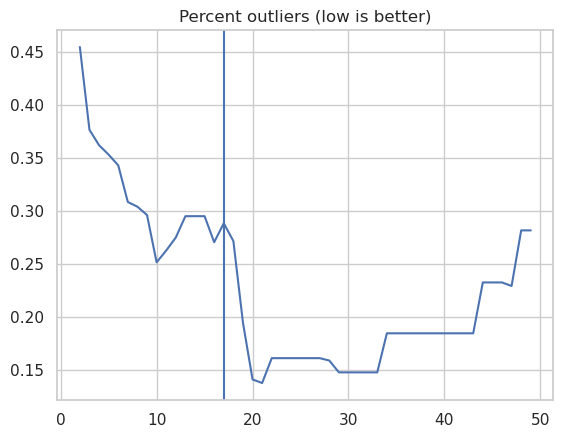

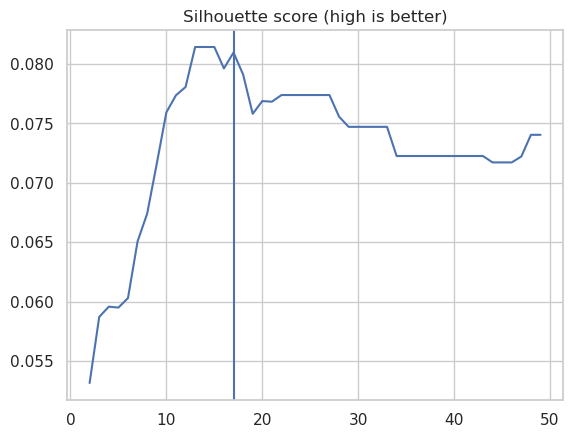

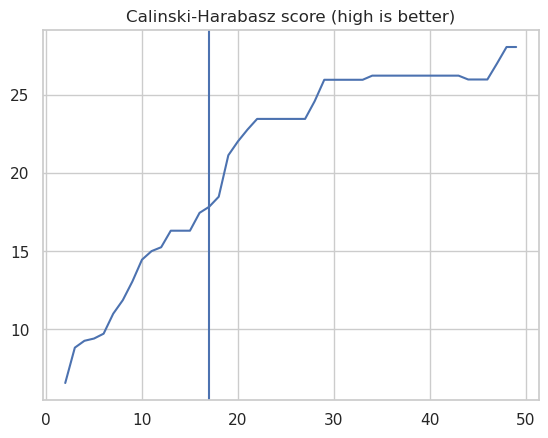

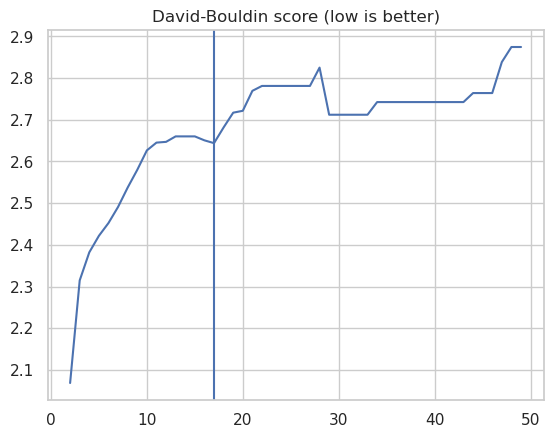

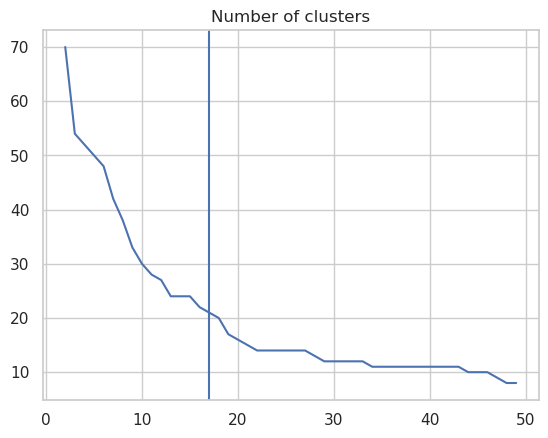

In [623]:
min_cluster_size = 17

plt.figure()
plt.plot(list(range(2, 50)), pos)
plt.axvline(min_cluster_size)
plt.title("Percent outliers (low is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 50)), scs)
plt.axvline(min_cluster_size)
plt.title("Silhouette score (high is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 50)), chs)
plt.axvline(min_cluster_size)
plt.title("Calinski-Harabasz score (high is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 50)), dbs)
plt.axvline(min_cluster_size)
plt.title("David-Bouldin score (low is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 50)), nclust)
plt.axvline(min_cluster_size)
plt.title("Number of clusters")
plt.show()

# Cluster data

In [431]:
%%time
vector_layers, location_layers, pointset_layers, metacluster_layers = build_cluster_layers(
    data_vectors, data_map, base_min_cluster_size=min_cluster_size, min_clusters=3,
)
print(len(vector_layers[0]))

21 17 45
7 45 104
3 104 247
21
CPU times: user 34.4 ms, sys: 7.83 ms, total: 42.3 ms
Wall time: 13.7 ms


# Extracting useful cluster information for topic naming

Next I'm going to need a little more information, since for distinctive sentences (and later on as well) it will help to know what nearby clusters are. We could write something to do this efficiently, but there aren't that many clusters so we'll just brute-force the whole thing.

In [432]:
layer_cluster_neighbors = [
    np.argsort(
        sklearn.metrics.pairwise_distances(layer, metric="cosine"), 
        axis=1
    )[:, :16]
    for layer in vector_layers
]

Now we can generate topical sentences (sentences most similar to the cluster centroid, up to some diversification) and distinctive sentences (sentences that most strongly distinguish this cluster from nearby ones) for all the clusters.

In [433]:
%%time
topical_sentences_per_cluster = [
    [
        topical_sentences_for_cluster(data_strings["Title"], data_vectors, pointset, cluster_vector)
        for pointset, cluster_vector in zip(pointset_layers[i], vector_layers[i])
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 778 ms, sys: 1.76 s, total: 2.54 s
Wall time: 157 ms


In [434]:
%%time
distinctive_sentences_per_cluster = [
    [
        distinctive_sentences_for_cluster(
            topic_num, data_strings["Title"], data_vectors, pointset_layers[i], layer_cluster_neighbors[i][topic_num]
        )
        for topic_num in range(len(pointset_layers[i]))
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 25.7 s, sys: 48.7 s, total: 1min 14s
Wall time: 3.15 s


Next I'm going to want some keywords for each cluster. I'm just stealing from other similar code I wrote here, so please excuse the mess -- this was just a "get it done" effort. In essence this is really much the same as BERTopic's c-TF-IDF except it uses the slightly newer supervised information weighting instead c-IDF. It also helps to use a decent n-gram range and beef up the min_df to get more informative keywords.

In [435]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True, min_df=25, token_pattern='(?u)\\b\\w[-\'\\w]+\\b', ngram_range=(1,4))
full_count_matrix = cv.fit_transform(data_strings["Title"] + " " + data_strings["Abstract"])
acceptable_vocab = [v for v in cv.vocabulary_ if v.split()[0] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS and v.split()[-1] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS]
acceptable_indices = [cv.vocabulary_[v] for v in acceptable_vocab]
full_count_matrix = full_count_matrix[:, acceptable_indices]
inverse_vocab = {i:w for i, w in enumerate(acceptable_vocab)}
vocab = acceptable_vocab
len(vocab)

CPU times: user 1.07 s, sys: 1.74 s, total: 2.81 s
Wall time: 427 ms


1049

In [436]:
vocab_vectors = dict(zip(vocab, embedding_model.encode(vocab, show_progress_bar=True)))

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [437]:
%%time
contrastive_keyword_layers = [
        contrastive_keywords_for_layer(
        full_count_matrix, 
        inverse_vocab, 
        pointset_layers[layer_num], 
        data_vectors,
        vocab_vectors,
    )
    for layer_num in range(len(pointset_layers))
]

CPU times: user 1.4 s, sys: 2.97 s, total: 4.37 s
Wall time: 279 ms


# Naming the lowest layer of topics

Now we get to the point of using an LLM to create topic names. I went through a few iterations of things like this, and this is what the prompt generation evolved into; if I was starting from scratch I think we could write this much more cleanly. Still, it gets the job done.

In [438]:
def create_prompt(
    i, 
    contrastive_keyword_layer=contrastive_keyword_layers[0], 
    topical_sentences_per_cluster=topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster=distinctive_sentences_per_cluster[0],
    base_cluster_neighbors=layer_cluster_neighbors[0],
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles:\n\n"
    prompt_text += "Distinguishing keywords for this group:\n - \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "\nSample topical titles from the group include:\n"
    for text in topical_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"
    prompt_text += "\nSample distinctive titles from the group include:\n"
    for text in distinctive_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in base_cluster_neighbors[i][:3]:
        for text in distinctive_sentences_per_cluster[n][:2]:
            prompt_text += f"- \"{text}\"\n"

    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords:\n - \"" + ", ".join(contrastive_keyword_layer[i][:8]) + "\" \n"
    prompt_text += "is:\n"
    return prompt_text

In [483]:
import anthropic

client = anthropic.Anthropic()

# Duplicate Llama api for calling
def llm(prompt, max_tokens=16, temperature=0.8):
    message = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=max_tokens,
        temperature=temperature,
        system="Give terse category names for the questions asked. Do not provide explanations for your responses." 
        "Make sure each topic name is sufficiently distinct from other topic groups."
        "All papers are, to some degree, about machine learning and oceanography, so using words like 'Machine Learning', 'Marine' may be redundant and should be mostly avoided.",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    }
                ]
            }
        ]
    )
    return message

Now we need out LLM. A quantized version of Mistral 7B is not bad, but pick the model that works for you. If you have a GPU this goes a lot faster. If you have a big GPU you will probably want a better model. In general the most powerful model that you can run on the hardware you have is likely your best bet.

In [484]:
# !wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/QuantFactory/Meta-Llama-3-8B-Instruct-GGUF/resolve/main/Meta-Llama-3-8B-Instruct.Q4_K_M.gguf
# !wget https://huggingface.co/QuantFactory/Meta-Llama-3-70B-Instruct-GGUF/resolve/main/Meta-Llama-3-70B-Instruct.Q4_K_M.gguf

In [485]:
# llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm = Llama(model_path="Meta-Llama-3-8B-Instruct.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm = Llama(model_path="Meta-Llama-3-70B-Instruct.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm()

Before we run this in earnest let's try it out on the first cluster to make sure it works.

In [486]:
llm(create_prompt(0), max_tokens=24, temperature=0.75)

Message(id='msg_01No26SX42t6qGbCiqUEHCo6', content=[ContentBlock(text='Arctic Sea Ice', type='text')], model='claude-3-opus-20240229', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=873, output_tokens=6))

Looks good enough. Obviously we'll need to clean up the output a little, but that's easy enough to add. Let's write a function to do the naming ...

In [487]:
def base_level_topic_names(
    topical_sentence_layer,
    distinctive_sentence_layer,
    contrastive_keyword_layer,
    base_cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt(
            i, 
            contrastive_keyword_layer=contrastive_keyword_layer, 
            topical_sentences_per_cluster=topical_sentence_layer,
            distinctive_sentences_per_cluster=distinctive_sentence_layer,
            base_cluster_neighbors=base_cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt).content[0].text
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))
        topic_names.append(topic_name)

    return topic_names

And away we go ...



In [488]:
%%time
layer0_topics = base_level_topic_names(
    topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster[0],
    contrastive_keyword_layers[0],
    layer_cluster_neighbors[0],
    to_topic_index=len(contrastive_keyword_layers[0])
)

  0%|          | 0/21 [00:00<?, ?it/s]

CPU times: user 194 ms, sys: 56.4 ms, total: 250 ms
Wall time: 1min 10s


In [489]:
layer0_topics

['Arctic Sea Ice',
 'Bioacoustic Monitoring',
 'Biogeochemical Cycles',
 'Ocean Color Remote Sensing',
 'Coastal Habitat Mapping',
 'Vessel Detection And Tracking',
 'Marine Ecosystem Dynamics',
 'Seasonal Climate Forecasting',
 'Ocean Modeling & Forecasting',
 'Oil Spill Monitoring',
 'Litter Detection',
 'Water Quality Modeling',
 'Harmful Algal Bloom Forecasting',
 'Storm Surge Prediction',
 'Coastal Flood Risk',
 'Species Distribution Modeling',
 'Species Distribution Modeling',
 'Ship Dynamics And Control',
 'Wave Forecasting',
 'Underwater Image Analysis',
 'Aerial Wildlife Surveys']

# Naming all the other layers of topics

Now we have the other layers to deal with. Since these are larger clusters it is harder to get representative sentences that cover the full breadth and still fit in the prompt context size. However we did keep track of sub-clusters and now we have names for all those sub-clusters, so we can provide that instead. Of course if there are too many sub-clusters that can be tricky as well. So pick out the topical sub-topic names and distinctive sub-topic names (with a large selection) -- we just need to embed all the cluster names we've got so far.

In [490]:
embeddings_of_layer0_topics = embedding_model.encode(layer0_topics, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [491]:
def topical_subtopics_for_cluster(
    metacluster, pointset, doc_vectors, base_layer_topic_names, base_layer_pointsets, n_subtopics=32
):
    centroid_vector = np.mean(doc_vectors[pointset], axis=0)
    subtopic_vectors = np.asarray([np.mean(doc_vectors[base_layer_pointsets[n]], axis=0) for n in metacluster])
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], subtopic_vectors, metric="cosine"))
    )[:2 * n_subtopics]
    candidate_neighbors = subtopic_vectors[candidate_neighbor_indices]
    topical_subtopic_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors, alpha=0.66, max_candidates=n_subtopics)
    ][:n_subtopics]
    topical_subtopics = [base_layer_topic_names[metacluster[i]] for i in topical_subtopic_indices]
    return topical_subtopics


def contrastive_subtopics_for_cluster(
    cluster_neighbors, meta_clusters, base_layer_topic_embeddings, base_layer_topic_names, n_subtopics=24
):
    topic_names = [base_layer_topic_names[x] for x in meta_clusters[cluster_neighbors[0]]]
    local_vectors = base_layer_topic_embeddings[sum([meta_clusters[x] for x in cluster_neighbors], [])]
    U, S, Vh = np.linalg.svd(local_vectors - local_vectors.mean(axis=0))
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(np.arange(len(cluster_neighbors)), [len(meta_clusters[x]) for x in cluster_neighbors])
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    topic_name_weights = np.sum(transformed_docs[:len(topic_names)] * iwt.information_weights_, axis=1)
    distinctive_topic_indices = np.argsort(topic_name_weights)[:n_subtopics * 3]
    distinctive_topic_vectors = base_layer_topic_embeddings[distinctive_topic_indices]
    diversified_candidates = diversify(
        base_layer_topic_embeddings[meta_clusters[cluster_neighbors[0]]].mean(axis=0), 
        distinctive_topic_vectors
    )
    distinctive_topic_indices = distinctive_topic_indices[diversified_candidates[:n_subtopics]]
    distinctive_sentences = [topic_names[i] for i in distinctive_topic_indices]
    return distinctive_sentences

Now we just need to build that information for all the layers and clusters ...

In [492]:
%%time
topical_subtopic_layers = [
    [
        topical_subtopics_for_cluster(
            metacluster_layers[layer_num][cluster_num],
            pointset_layers[layer_num][cluster_num],
            data_vectors,
            layer0_topics,
            pointset_layers[0],
            n_subtopics=32
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 8.23 ms, sys: 277 µs, total: 8.5 ms
Wall time: 8.4 ms


In [493]:
%%time
contrastive_subtopic_layers = [
    [
        contrastive_subtopics_for_cluster(
            layer_cluster_neighbors[layer_num][cluster_num],
            metacluster_layers[layer_num],
            embeddings_of_layer0_topics,
            layer0_topics,
            n_subtopics=24
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 1.42 s, sys: 1.32 s, total: 2.74 s
Wall time: 115 ms


/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:254: RuntimeWarning: invalid value encountered in power
  self.information_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:254: RuntimeWarning: invalid value encountered in power
  self.information_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(


Given that we are using the sub-topic names we need a different prompt construction.

In [494]:
def create_prompt_from_subtopics(
    i,
    contrastive_keyword_layer,
    subtopic_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles that are all on the same topic:\n\n"
    prompt_text += "Distinguishing keywords for this group: \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "Sample sub-topics from the group include:\n"
    for text in subtopic_layer[i][:24]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample topical titles include:\n"
    for text in topical_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample distinctive titles of the topic include:\n"
    for text in distinctive_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"        
    

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in topical_sentences_layer[n][:2]:
            prompt_text += f"- \"{text}\"\n"
    prompt_text += "\nSub-topics from different but similar groups include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in subtopic_layer[n][:4]:
            prompt_text += f"- \"{text}\"\n"    
            
    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords \"" + ", ".join(contrastive_keyword_layer[i]) + "\" "
    prompt_text += "is:"
    return prompt_text

Then we just need a function for do all the naming and clean uip the output names ...

In [495]:
def subtopics_and_keywords_to_topic_name(
    subtopics_layer,
    contrastive_keyword_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt_from_subtopics(
            i, 
            contrastive_keyword_layer, 
            subtopics_layer,
            topical_sentences_layer,
            distinctive_sentences_layer,
            cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt).content[0].text
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))

        topic_names.append(topic_name)

    return topic_names

And we can start naming topics for the other layers ...

In [496]:
%%time
layer_n_topics = [subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[i], contrastive_subtopic_layers[i])],
    contrastive_keyword_layers[i+1],
    topical_sentences_per_cluster[i+1],
    distinctive_sentences_per_cluster[i+1],
    layer_cluster_neighbors[i+1],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[i]),
) for i in trange(len(topical_subtopic_layers))]

all_layer_topics = [layer0_topics, *layer_n_topics]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 671 ms, sys: 1.62 s, total: 2.29 s
Wall time: 31 s


The last problem that tends to occur is that we end up repeating topic names, particulary having high level topic names get repeated at lower levels where we want something more specific. But we can lookmfor those cases and try to get the LLM to generate a more specific topic name.

In [497]:
def create_final_remedy_prompt(original_topic_names, docs, vector_array, pointset, centroid_vector):
    sentences = topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=64)
    prompt_text = "A set of titles from machine learning articles was described as having a topic of one of " + ", ".join(original_topic_names) + ".\n"
    prompt_text += "These topic names were not specific enough and were shared with other different but similar groups of titles.\n"
    prompt_text += "A sampling of titles from this specific set of titles includes:\n"
    for sentence in np.random.choice(sentences, size=min(len(sentences), 64), replace=False):
        prompt_text += f"- {sentence}\n"

    prompt_text += f"\n\nThe current name for this topic of these paragraphs is: {original_topic_names[-1]}\n"
    prompt_text += "A better and more specific name that still captures the topic of these article titles is: "
    return prompt_text

In [498]:
all_layer_topics

[['Arctic Sea Ice',
  'Bioacoustic Monitoring',
  'Biogeochemical Cycles',
  'Ocean Color Remote Sensing',
  'Coastal Habitat Mapping',
  'Vessel Detection And Tracking',
  'Marine Ecosystem Dynamics',
  'Seasonal Climate Forecasting',
  'Ocean Modeling & Forecasting',
  'Oil Spill Monitoring',
  'Litter Detection',
  'Water Quality Modeling',
  'Harmful Algal Bloom Forecasting',
  'Storm Surge Prediction',
  'Coastal Flood Risk',
  'Species Distribution Modeling',
  'Species Distribution Modeling',
  'Ship Dynamics And Control',
  'Wave Forecasting',
  'Underwater Image Analysis',
  'Aerial Wildlife Surveys'],
 ['Ocean Modeling & Forecasting',
  'Species Distribution Modeling',
  'Water Quality',
  'Coastal Hazards',
  'Wave & Ship Dynamics',
  'Oil Spill And Debris Detection',
  'Image Object Detection'],
 ['Wave & Storm Modeling',
  'Aquatic Monitoring',
  'Species Distribution & Habitats']]

In [499]:
from tqdm.auto import trange

And now we just go through the layers and fix up topic names; generating the topic label vectors suitable for input directly into [DataMapPlot](https://github.com/TutteInstitute/datamapplot):

In [500]:
%%time
layer_clusters = [np.full(data_map.shape[0], "Unlabelled", dtype=object) for i in range(len(all_layer_topics))]
unique_names = set([])

for n in range(len(all_layer_topics) - 1, -1, -1):
    print(f"Working on layer {n}")
    for i, (name, indices) in enumerate(tqdm.auto.tqdm(list(zip(all_layer_topics[n], pointset_layers[n])))):
        # if i % 100 == 0:
        # print(f"Working on cluster {i}")
        n_attempts = 0
        recapped_name = string.capwords(name.strip(string.punctuation + string.whitespace))
        unique_name = recapped_name
        original_topic_names = [unique_name]
        while unique_name in unique_names and n_attempts < 8:
            prompt_text = create_final_remedy_prompt(
                original_topic_names, data_strings["Title"], data_vectors, indices, vector_layers[n][i]
            )
            unique_name = llm(prompt_text, max_tokens=36).content[0].text
            if "\n" in unique_name:
                unique_name = unique_name.lstrip("\n ").lstrip("1. ")
                unique_name = unique_name.split("\n")[0]
            unique_name = string.capwords(unique_name.strip(string.punctuation + string.whitespace))
            original_topic_names.append(unique_name)
            n_attempts += 1
        if n_attempts > 0:
            print(f"{name} --> {unique_name} after {n_attempts} attempts")
        unique_names.add(unique_name)
        layer_clusters[n][indices] = unique_name

Working on layer 2


  0%|          | 0/3 [00:00<?, ?it/s]

Working on layer 1


  0%|          | 0/7 [00:00<?, ?it/s]

Working on layer 0


  0%|          | 0/21 [00:00<?, ?it/s]

Ocean Modeling & Forecasting --> Climate & Ocean Dynamics Modeling after 1 attempts
Species Distribution Modeling --> Habitat Suitability Prediction after 1 attempts
Species Distribution Modeling --> Habitat Suitability Modeling after 1 attempts
CPU times: user 795 ms, sys: 2.04 s, total: 2.84 s
Wall time: 7.23 s


In [501]:
unique_names

{'Aerial Wildlife Surveys',
 'Aquatic Monitoring',
 'Arctic Sea Ice',
 'Bioacoustic Monitoring',
 'Biogeochemical Cycles',
 'Climate & Ocean Dynamics Modeling',
 'Coastal Flood Risk',
 'Coastal Habitat Mapping',
 'Coastal Hazards',
 'Habitat Suitability Modeling',
 'Habitat Suitability Prediction',
 'Harmful Algal Bloom Forecasting',
 'Image Object Detection',
 'Litter Detection',
 'Marine Ecosystem Dynamics',
 'Ocean Color Remote Sensing',
 'Ocean Modeling & Forecasting',
 'Oil Spill And Debris Detection',
 'Oil Spill Monitoring',
 'Seasonal Climate Forecasting',
 'Ship Dynamics And Control',
 'Species Distribution & Habitats',
 'Species Distribution Modeling',
 'Storm Surge Prediction',
 'Underwater Image Analysis',
 'Vessel Detection And Tracking',
 'Water Quality',
 'Water Quality Modeling',
 'Wave & Ship Dynamics',
 'Wave & Storm Modeling',
 'Wave Forecasting'}

A quick glance at the topic names generated for the two uppermost layers shows we mostly did a decent job. Obviously with a little more care we could do a lot better, but for something essentially entirely auotmated this is not so bad. At worst you can go in an clean up some of the topic names by hand.

In [502]:
all_layer_topics[-2]

['Ocean Modeling & Forecasting',
 'Species Distribution Modeling',
 'Water Quality',
 'Coastal Hazards',
 'Wave & Ship Dynamics',
 'Oil Spill And Debris Detection',
 'Image Object Detection']

In [503]:
all_layer_topics[-1]

['Wave & Storm Modeling',
 'Aquatic Monitoring',
 'Species Distribution & Habitats']

# Create an interactive plot and save as HTML

In [504]:
plot = datamapplot.create_interactive_plot(
    data_map,
    layer_clusters[0],
    layer_clusters[1],
    # font_family="Cinzel",
    font_family="Playfair Display SC",
    cluster_boundary_polygons=False,
    # cluster_boundary_line_width=6,
    title="Oceanography Papers Using Machine Learning",
    sub_title="Embeddings of titles and abstracts for papers using machine learning for oceanographic research",
    enable_search=True,
    darkmode=False,
    use_medoids=True,
    color_label_text=True,
    # inline_data=False,
    # offline_data_prefix="bb-ai-1",
    on_click="window.open(`http://google.com/search?q=\"{hover_text}\"`)",
    # cmap=matplotlib.colormaps.get_cmap("cet_glasbey"),
    min_fontsize=20,
    max_fontsize=64,
    # marker_size_array=[len(x) for x in dataset['Title']],
    # point_radius_min_pixels=1,
    # point_radius_max_pixels=18,
    hover_text=dataset['Title'],
)
plot

<InteractiveFigure width=100% height=800>

In [505]:
plot.save("index.html")

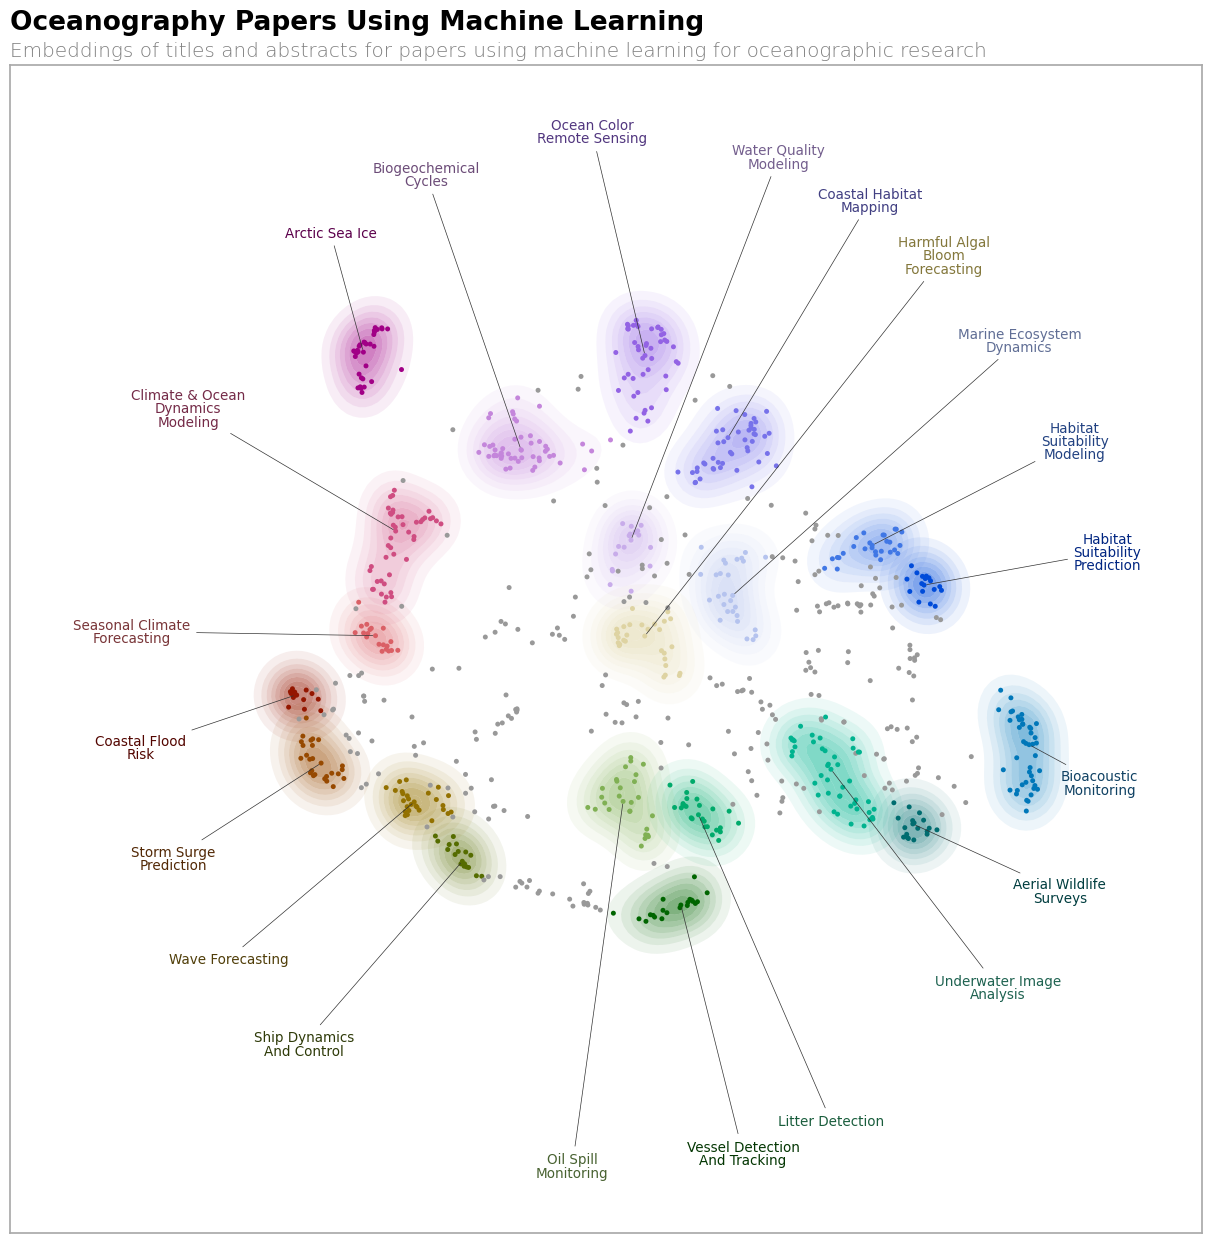

In [506]:
# Static visualization
fig, ax = datamapplot.create_plot(
    data_map,
    layer_clusters[0],
    title="Oceanography Papers Using Machine Learning",
    sub_title="Embeddings of titles and abstracts for papers using machine learning for oceanographic research",
    darkmode=False,
    use_medoids=True,
    # label_font_size=11,
    # label_wrap_width=10,
)

In [507]:
fig.savefig("oceanography-ml-landscape.png", bbox_inches="tight")

# Export XLSX

(895, 768)

In [617]:
clusters_df = pd.DataFrame(dataset[["Title", "Abstract", 'Manual Labelling']])
clusters_df['embedding_alpha'] = data_map[:,0]
clusters_df['embedding_beta'] = data_map[:,1]
# clusters_df['embedding_full'] = list(map(str, data_vectors))
clusters_df

,Title,Abstract,Manual Labelling,embedding_alpha,embedding_beta
0,Comparative species abundance modeling of Capi...,Capitellid polychaetes are ubiquitous througho...,Species distribution,7.670140,2.875324
1,Ocean Fronts and Their Acoustic Effects: A Review,As one of the widespread physical phenomena in...,Acoustic classification,9.448993,-0.000632
2,A Survey of Underwater Acoustic Target Recogni...,Underwater acoustic target recognition (UATR) ...,Acoustic classification,9.592367,-0.085786
3,Present status and challenges of underwater ac...,Future naval warfare has placed high demands o...,Acoustic classification,9.574535,-0.074864
4,Categorizing Shallow Marine Soundscapes Using ...,Natural marine soundscapes are being threatene...,Acoustic classification,9.536500,0.610426
...,...,...,...,...,...
890,Collaboration and engagement produce more acti...,Aquatic telemetry technology generates new kno...,Species distribution,8.103353,0.769560
891,Exploring seafloor stretching in mariana trenc...,Multibeam bathymetry data could represent near...,Sea floor mapping and bathymetry,6.375174,0.583849
892,Source apportionment using receptor model base...,Source apportionment studies have been perform...,Ocean chemistry detection,3.573824,4.529801
893,Portable Imaging Flow-Cytometer Using Deep Lea...,We demonstrate deep learning assisted holograp...,Underwater photography,6.319487,0.989190


In [618]:
clusters_df["Topic"] = layer_clusters[0]
clusters_df["MetaTopic"] = layer_clusters[1]
# clusters_df["MetaMetaTopic"] = layer_clusters[2]

clusters_df.sort_values(["MetaTopic", "Topic"], inplace=True)

clusters_df

,Title,Abstract,Manual Labelling,embedding_alpha,embedding_beta,Topic,MetaTopic
123,Drivers of mangrove vulnerability and resilien...,The North Atlantic Basin (NAB) has seen an inc...,Coastal geomorphology,0.849066,1.106862,Coastal Flood Risk,Coastal Hazards
146,Comparative Coastal Risk Index (CCRI): A multi...,As the world’s population grows to a projected...,Coastal geomorphology,0.583557,1.154855,Coastal Flood Risk,Coastal Hazards
147,Does planned retreat matter? Investigating lan...,Coastal regions worldwide are during the proce...,Coastal geomorphology,0.527116,1.175586,Coastal Flood Risk,Coastal Hazards
380,Advancing flood damage modeling for coastal Al...,Flooding is a global threat and predicting flo...,Natural disaster forecasting,0.879849,0.972498,Coastal Flood Risk,Coastal Hazards
383,Adaptation strategies for future coastal flood...,Climate change is contributing to an increasin...,Natural disaster forecasting,0.531190,1.228736,Coastal Flood Risk,Coastal Hazards
...,...,...,...,...,...,...,...
779,Ocean data classification using unsupervised m...,Wave-wind hybrid energy systems have become a ...,Power generation,2.065600,-0.154958,Wave Forecasting,Wave & Ship Dynamics
785,Image-based measurement of wave interactions w...,"Over the past decade, the use of imaging devic...",Underwater photography,2.453395,-0.019856,Wave Forecasting,Wave & Ship Dynamics
787,Derivation of wave overtopping formulas for ve...,To measure the wave overtopping rate over a co...,Water level prediciton,2.447351,-0.229091,Wave Forecasting,Wave & Ship Dynamics
801,Characterization of Extreme Wave Conditions fo...,Best practices and international standards for...,Natural disaster forecasting,1.965440,-0.193866,Wave Forecasting,Wave & Ship Dynamics


Cleanup and add in the manual labels

In [619]:
# manual_df = dataset[['Title', 'Abstract', 'Manual Labelling']].copy()
# manual_df.reset_index(inplace=True)
# Cleanup categories
clusters_df['Manual Labelling Cleaned'] = clusters_df['Manual Labelling'].str.split("\n")
clusters_df = clusters_df.explode('Manual Labelling Cleaned')
clusters_df['Manual Labelling Cleaned'] = clusters_df['Manual Labelling Cleaned'] \
    .str.replace("?","")\
    .str.replace(",","")\
    .str.lower() \
    .str.strip() \
    .str.replace("modeling", "modelling") \
    .str.replace("harmal", "harmful") \
    .str.replace("corrision", "corrosion") \
    .str.replace("ocean circulation and currents", "ocean currents and circulation") \
    .str.replace("prediciton", "prediction") \
    .str.replace("chemstry", "chemistry") \
    .str.replace("navigatin", "navigation") \
    .str.replace("natural disaster detection", "natural disaster forecasting") \
    .str.replace("invasive species monitoring", "species monitoring") \
    .map(lambda t: string.capwords(t))

# drop blank
clusters_df = clusters_df[~(clusters_df['Manual Labelling Cleaned'] == "")]
del clusters_df['Manual Labelling']
clusters_df

,Title,Abstract,embedding_alpha,embedding_beta,Topic,MetaTopic,Manual Labelling Cleaned
123,Drivers of mangrove vulnerability and resilien...,The North Atlantic Basin (NAB) has seen an inc...,0.849066,1.106862,Coastal Flood Risk,Coastal Hazards,Coastal Geomorphology
146,Comparative Coastal Risk Index (CCRI): A multi...,As the world’s population grows to a projected...,0.583557,1.154855,Coastal Flood Risk,Coastal Hazards,Coastal Geomorphology
147,Does planned retreat matter? Investigating lan...,Coastal regions worldwide are during the proce...,0.527116,1.175586,Coastal Flood Risk,Coastal Hazards,Coastal Geomorphology
380,Advancing flood damage modeling for coastal Al...,Flooding is a global threat and predicting flo...,0.879849,0.972498,Coastal Flood Risk,Coastal Hazards,Natural Disaster Forecasting
383,Adaptation strategies for future coastal flood...,Climate change is contributing to an increasin...,0.531190,1.228736,Coastal Flood Risk,Coastal Hazards,Natural Disaster Forecasting
...,...,...,...,...,...,...,...
779,Ocean data classification using unsupervised m...,Wave-wind hybrid energy systems have become a ...,2.065600,-0.154958,Wave Forecasting,Wave & Ship Dynamics,Power Generation
785,Image-based measurement of wave interactions w...,"Over the past decade, the use of imaging devic...",2.453395,-0.019856,Wave Forecasting,Wave & Ship Dynamics,Underwater Photography
787,Derivation of wave overtopping formulas for ve...,To measure the wave overtopping rate over a co...,2.447351,-0.229091,Wave Forecasting,Wave & Ship Dynamics,Water Level Prediction
801,Characterization of Extreme Wave Conditions fo...,Best practices and international standards for...,1.965440,-0.193866,Wave Forecasting,Wave & Ship Dynamics,Natural Disaster Forecasting


In [620]:
# Rejoin exploded columns
clusters_df = clusters_df.groupby(["Title", "Abstract", "Topic", "MetaTopic", "embedding_alpha", "embedding_beta"]).agg({'Manual Labelling Cleaned': ', '.join}).reset_index()
clusters_df

,Title,Abstract,Topic,MetaTopic,embedding_alpha,embedding_beta,Manual Labelling Cleaned
0,2023 5th International Conference on Environme...,The proceedings contain 118 papers. The topics...,Unlabelled,Unlabelled,4.346168,1.266299,"Ocean Chemistry Detection, Contaminated Ocean ..."
1,20th century cooling of the deep ocean contrib...,The historical evolution of Earth’s energy imb...,Biogeochemical Cycles,Unlabelled,2.826810,3.990208,Ocean Currents And Circulation
2,21 000 birds in 4.5 h: efficient large-scale s...,We address the task of automatically detecting...,Aerial Wildlife Surveys,Image Object Detection,8.058338,-0.504681,Species Distribution
3,A 10-year record of Arctic summer sea ice free...,Satellite observations of pan-Arctic sea ice t...,Arctic Sea Ice,Unlabelled,1.488173,5.255651,Ice Monitoring
4,A Bayesian Deep Learning Approach to Near-Term...,Since model bias and associated initialization...,Climate & Ocean Dynamics Modeling,Ocean Modeling & Forecasting,1.527949,2.390450,Climate Modelling
...,...,...,...,...,...,...,...
890,Wild salmon enumeration and monitoring using d...,Pacific salmon have experienced declining abun...,Underwater Image Analysis,Image Object Detection,7.642435,-0.301564,Biodiversity Monitoring
891,Winter Precipitation and Summer Temperature Pr...,Climate change can have strong effects on aqua...,Water Quality Modeling,Water Quality,4.700716,2.965399,Natural Disaster Forecasting
892,Year-round sea ice and snow characterization f...,Satellite microwave observations from 1.4 to 3...,Arctic Sea Ice,Unlabelled,1.539828,5.414557,Ice Monitoring
893,eWaSR—An Embedded-Compute-Ready Maritime Obsta...,Maritime obstacle detection is critical for sa...,Vessel Detection And Tracking,Unlabelled,5.639313,-1.154923,Shipping Navigation And Logistics


In [621]:
clusters_df.to_excel("Topic_Results.xlsx", index=False)

# Comparing LLM models to manual labels

In [585]:
manual_df = dataset[['Title', 'Abstract', 'Manual Labelling']].copy()
manual_df.reset_index(inplace=True)
# Cleanup categories
manual_df['FirstLabel'] = manual_df['Manual Labelling'].str.split("\n").str[0]\
    .str.replace("?","")\
    .str.replace(",","")\
    .str.lower() \
    .str.strip() \
    .str.replace("modeling", "modelling") \
    .str.replace("harmal", "harmful") \
    .str.replace("corrision", "corrosion") \
    .str.replace("ocean circulation and currents", "ocean currents and circulation") \
    .str.replace("prediciton", "prediction") \
    .map(lambda t: string.capwords(t))
manual_df['FirstLabel'].unique()

array(['Species Distribution', 'Acoustic Classification',
       'Algae And Harmful Algae Bloom Detection',
       'Biodiversity Monitoring', 'Climate Engineering',
       'Climate Modelling', 'Coastal Geomorphology',
       'Contaminated Ocean Water Detection',
       'Coral Reef Monitoring And Bleaching',
       'Detection Of Man-made Objects', 'Disease Detection',
       'Eelgrass Monitoring', 'Engineering', 'Fishing And Seafood',
       'Fleet Monitoring', 'Ice Monitoring',
       'Infrastructure Monitoring And Corrosion Detection',
       'Species Monitoring', 'Marine Ecology', 'Microplastics',
       'Natural Disaster Forecasting', 'Ocean Chemistry Detection',
       'Ocean Currents And Circulation', 'Other',
       'Plankton Identification', 'Power Generation', 'Regime Dynamics',
       'Resource Management', 'Sea Floor Mapping And Bathymetry',
       'Seaweed Monitoring', 'Shipping Navigation And Logistics',
       'Taxonomy', 'Underwater Photography', 'Unmanned Vehicles',
    

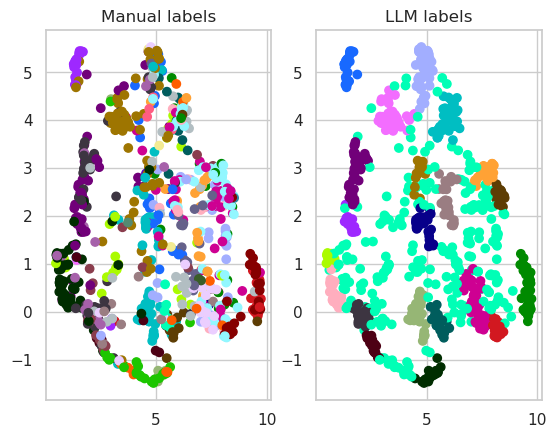

In [558]:
import glasbey
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure()
ax = plt.subplot(1,2,1)
uniques, X = np.unique(manual_df['FirstLabel'], return_inverse=True)
p = glasbey.create_palette(palette_size=len(uniques))
cmp = ListedColormap(p)
plt.title("Manual labels")
plt.scatter(*data_map.T, c=X, cmap=cmp)

ax = plt.subplot(1,2,2)
uniques, X = np.unique(layer_clusters[0], return_inverse=True)
p = glasbey.create_palette(palette_size=len(uniques))
cmp = ListedColormap(p)
plt.title("LLM labels")
plt.scatter(*data_map.T, c=X, cmap=cmp)

plt.show()

We can use Jaccard Similarity to test which llm labelled cluster is most similar for each of the manually labelled clusters

In [559]:
from typing import Any

def jaccard_similarity(a: set[Any], b: set[Any]):
    """a and b are sets of the Titles or ids for papers in a particular cluster"""
    intersect = len(a.intersection(b))
    union = len(a.union(b))
    return intersect / union

In [560]:
d = []
for manual_label in manual_df['FirstLabel'].unique():
    for llm_label in np.unique(layer_clusters[0]):
        ms = set(manual_df[manual_df['FirstLabel'] == manual_label]['Title'])
        ls = set(clusters_df[clusters_df['Topic'] == llm_label]['Title'])
        similarity = jaccard_similarity(ms, ls)

        d.append({
            "Manual Label": manual_label,
            "LLM Label": llm_label,
            "Jaccard Similarity": similarity
        })
        
d = pd.DataFrame(d)
dp = d.pivot(columns='Manual Label', index='LLM Label', values='Jaccard Similarity') 

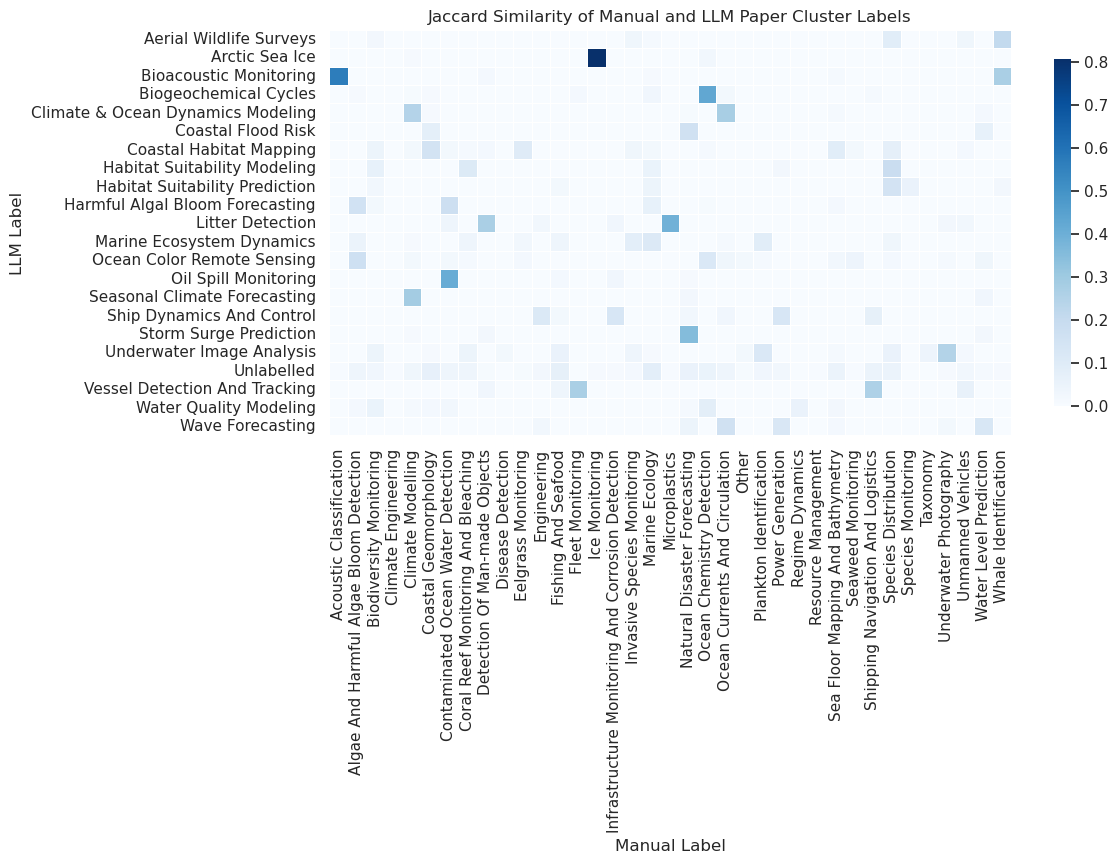

In [561]:
import seaborn as sns

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(dp, cmap="Blues", linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt=".1f")
g.set(title="Jaccard Similarity of Manual and LLM Paper Cluster Labels", aspect="equal")
plt.show()

## Instead of first label, try duplicating data when multiple labels exist

In [562]:
manual_df = dataset[['Title', 'Abstract', 'Manual Labelling']].copy()
manual_df.reset_index(inplace=True)
# Cleanup categories
manual_df['Label'] = manual_df['Manual Labelling'].str.split("\n")
manual_df = manual_df.explode("Label", ignore_index=True).reset_index()
manual_df['Label'] = manual_df['Label'].str.replace("?","")\
    .str.replace(",","")\
    .str.lower() \
    .str.strip() \
    .str.replace("modeling", "modelling") \
    .str.replace("harmal", "harmful") \
    .str.replace("corrision", "corrosion") \
    .str.replace("ocean circulation and currents", "ocean currents and circulation") \
    .str.replace("prediciton", "prediction") \
    .str.replace("chemstry", "chemistry") \
    .str.replace("navigatin", "navigation") \
    .str.replace("natural disaster detection", "natural disaster forecasting") \
    .str.replace("invasive species monitoring", "species monitoring") \
    .map(lambda t: string.capwords(t))
manual_df = manual_df[~(manual_df["Label"] == "")]
manual_df['Label'].unique()


array(['Species Distribution', 'Acoustic Classification',
       'Biodiversity Monitoring', 'Marine Ecology', 'Fishing And Seafood',
       'Natural Disaster Forecasting', 'Whale Identification',
       'Algae And Harmful Algae Bloom Detection',
       'Plankton Identification', 'Eelgrass Monitoring',
       'Ocean Chemistry Detection', 'Unmanned Vehicles',
       'Climate Engineering', 'Climate Modelling',
       'Contaminated Ocean Water Detection', 'Coastal Geomorphology',
       'Ocean Currents And Circulation',
       'Sea Floor Mapping And Bathymetry', 'Water Level Prediction',
       'Coral Reef Monitoring And Bleaching',
       'Detection Of Man-made Objects', 'Disease Detection',
       'Engineering', 'Fleet Monitoring',
       'Shipping Navigation And Logistics', 'Ice Monitoring',
       'Infrastructure Monitoring And Corrosion Detection',
       'Species Monitoring', 'Microplastics', 'Other', 'Power Generation',
       'Underwater Photography', 'Regime Dynamics', 'Resource M

In [563]:
d = []
for manual_label in manual_df['Label'].unique():
    for llm_label in np.unique(layer_clusters[0]):
        ms = set(manual_df[manual_df['Label'] == manual_label]['Title'])
        ls = set(clusters_df[clusters_df['Topic'] == llm_label]['Title'])
        similarity = jaccard_similarity(ms, ls)

        d.append({
            "Manual Label": manual_label,
            "LLM Label": llm_label,
            "Jaccard Similarity": similarity
        })
        
d = pd.DataFrame(d)
dp = d.pivot(columns='Manual Label', index='LLM Label', values='Jaccard Similarity') 

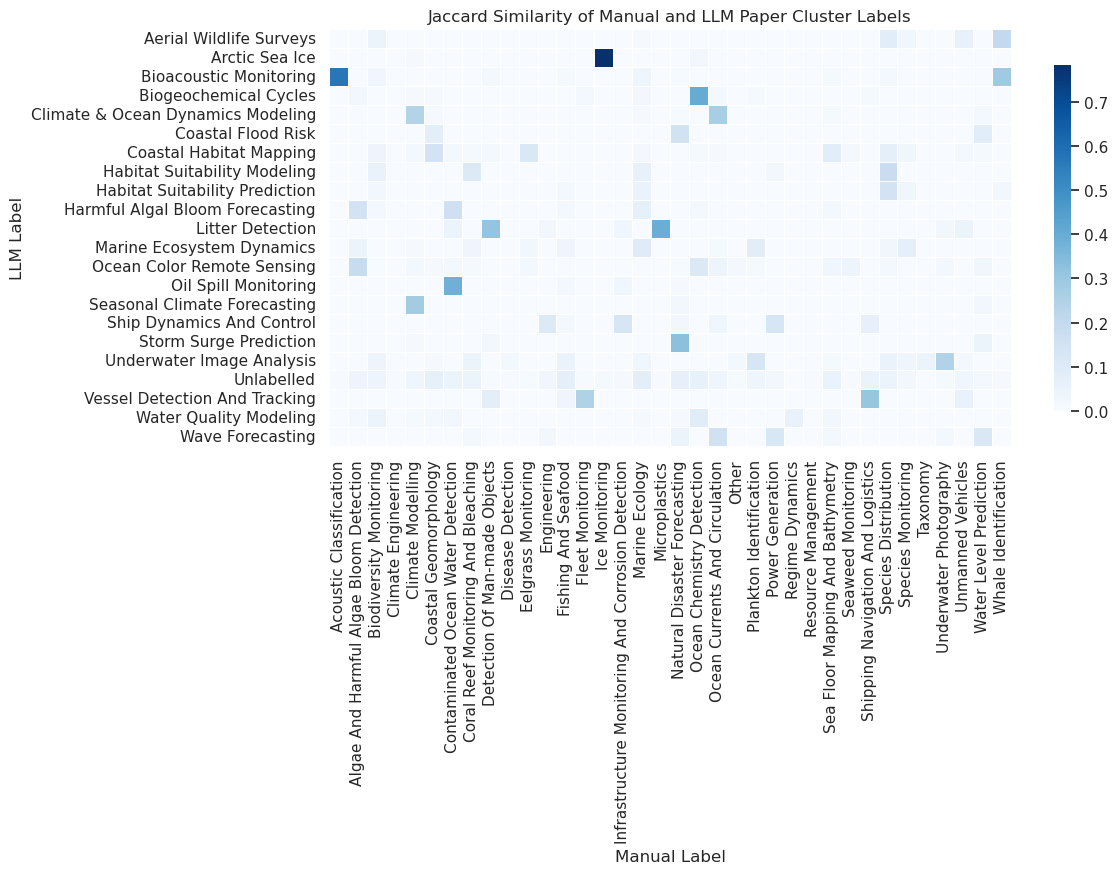

In [564]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(dp, cmap="Blues", linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt=".1f")
g.set(title="Jaccard Similarity of Manual and LLM Paper Cluster Labels", aspect="equal")
plt.show()

I think this shows that some of our clusters are well aligned with the LLM clusters (e.g. Arctic Ice Monitoring) but otherwise are a bit chaotic. Next, I'll look at the Manually labelled clusters and compute some statistics about cluster variance using the embeddings

# Manually-labelled Cluster Cohesion (??)

In [565]:
# manual_df

for manual_label in manual_df['Label'].unique():
    sub_df = manual_df[manual_df['Label'] == manual_label]
    print(f"count: {str(len(sub_df)):2} - {manual_label:40s} ")


count: 69 - Species Distribution                     
count: 26 - Acoustic Classification                  
count: 28 - Biodiversity Monitoring                  
count: 62 - Marine Ecology                           
count: 33 - Fishing And Seafood                      
count: 67 - Natural Disaster Forecasting             
count: 28 - Whale Identification                     
count: 41 - Algae And Harmful Algae Bloom Detection  
count: 24 - Plankton Identification                  
count: 10 - Eelgrass Monitoring                      
count: 92 - Ocean Chemistry Detection                
count: 16 - Unmanned Vehicles                        
count: 1  - Climate Engineering                      
count: 57 - Climate Modelling                        
count: 62 - Contaminated Ocean Water Detection       
count: 39 - Coastal Geomorphology                    
count: 53 - Ocean Currents And Circulation           
count: 28 - Sea Floor Mapping And Bathymetry         
count: 20 - Water Level Pred

In [567]:
data_map.shape

(895, 2)

In [568]:
manual_df.shape

(971, 6)